In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
# Using Inspector to view table
inspector = inspect(engine)

columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
first_mea = session.query(Measurement).first()
first_mea.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x109e202e8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

# Exploratory Climate Analysis

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Latest Date in the data set provided
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
latest_date = "".join([x for x in latest_date])

# Set date of a year ago
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Only return 1 year worth of data
precp_year_ago = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= year_ago).\
    filter(Measurement.prcp != "None").\
    group_by(Measurement.date).all()

# Create df
df = pd.DataFrame(precp_year_ago)
df.head()

,date,prcp
0,2016-08-23,0.70
1,2016-08-24,1.45
2,2016-08-25,0.11
3,2016-08-26,0.01
4,2016-08-27,0.12


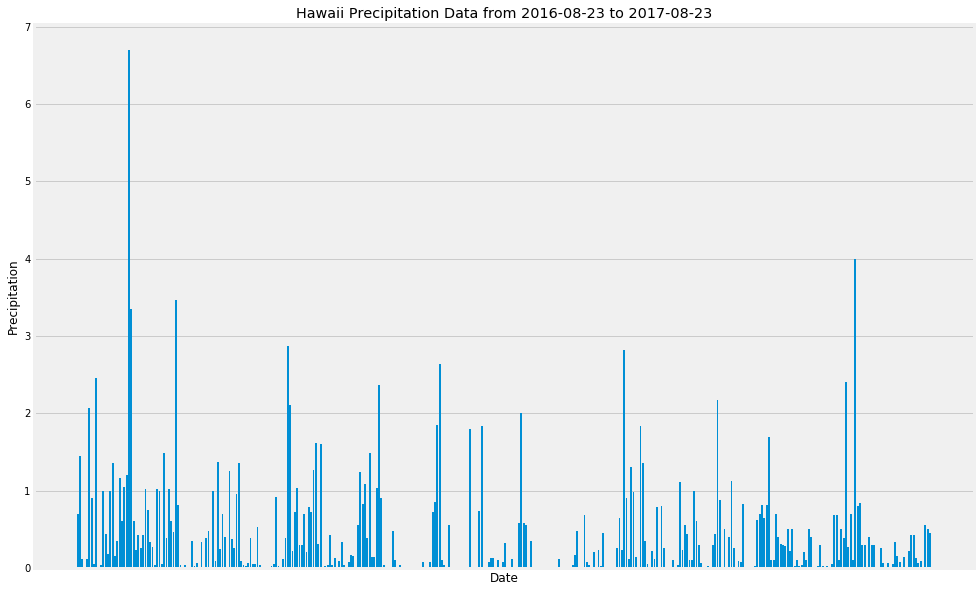

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.figure(figsize=(15,10))
plt.title(f"Hawaii Precipitation Data from {year_ago} to {latest_date}")
plt.xlabel("Date")
plt.ylabel("Precipitation")

# Plot graph
plt.xticks([])
plt.bar(df.date, df.prcp)
plt.savefig("Images/hawaii_prcp_data.png", bbox_inches = "tight")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,366.000000
mean,0.414536
std,0.690504
min,0.000000
25%,0.000000
50%,0.125000
75%,0.550000
max,6.700000


In [15]:
# How many stations are available in this dataset?
station_count = session.query(Station).count()
station_count

9

In [16]:
# What are the most active stations?
# List the stations and the counts in descending order.
stations_active_rank = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).\
    all()
stations_active_rank 

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_station = stations_active_rank[0][0]
highest_temp = session.query(func.max(Measurement.tobs)).\
    filter_by(station=most_active_station).\
    all()

avg_temp = session.query(func.avg(Measurement.tobs)).\
    filter_by(station=most_active_station).\
    all()

lowest_temp = session.query(func.min(Measurement.tobs)).\
    filter_by(station=most_active_station).\
    all()

print(highest_temp)
print(avg_temp)
print(lowest_temp)

[(85.0,)]
[(71.66378066378067,)]
[(54.0,)]


In [18]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_yr_high_temp = session.query(Measurement.tobs).\
    filter_by(station=most_active_station).\
    filter(Measurement.date >= year_ago).\
    all()
            
# Make it to data frame
tobs_df = pd.DataFrame(last_yr_high_temp)
tobs_df.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


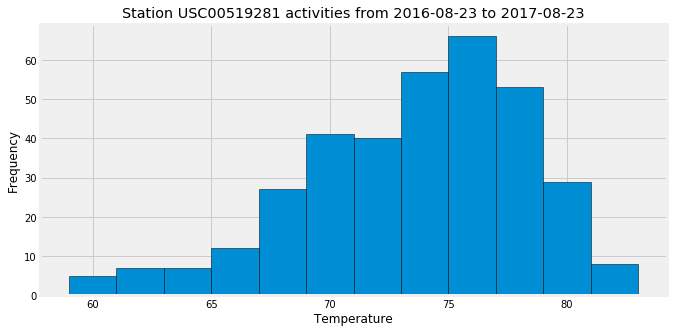

In [19]:
plt.figure(figsize=(10,5))
plt.hist(tobs_df["tobs"], bins=12, edgecolor="black")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.title(f"Station {most_active_station} activities from {year_ago} to {latest_date}")
plt.savefig("Images/most_active_station_hist.png", bbox_inches = "tight")
plt.show()

In [20]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [21]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = session.query(Measurement.date).\
    filter(Measurement.date >= year_ago).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    filter(func.strftime("%d", Measurement.date) == "01").\
    first()

trip_end = session.query(Measurement.date).\
    filter(Measurement.date >= year_ago).\
    filter(func.strftime("%m", Measurement.date) == "06").\
    filter(func.strftime("%d", Measurement.date) == "15").\
    first()

trip_start = "".join([x for x in trip_start])
trip_end = "".join([x for x in trip_end])

print(f"Going Hawaii on {trip_start} and back on {trip_end}")

print(calc_temps(trip_start, trip_end))


Going Hawaii on 2017-06-01 and back on 2017-06-15
[(72.0, 77.42268041237114, 83.0)]


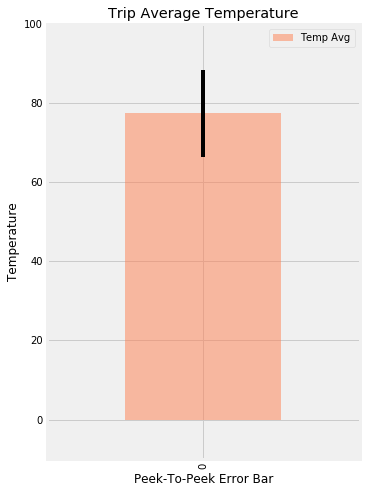

In [22]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_data = calc_temps(trip_start, trip_end)
trip_df = pd.DataFrame(trip_data, columns = ["Temp Min", "Temp Avg", "Temp Max"])

yerr = trip_df["Temp Max"] - trip_df["Temp Min"]
plt.title(f"Trip Average Temperature")
plt.xlabel("Peek-To-Peek Error Bar")
plt.ylabel("Temperature")
plt.ylim(-10, 100)
trip_avg_temp = trip_df["Temp Avg"]
trip_avg_temp.plot(kind="bar", yerr=yerr, color="coral", alpha=0.5, figsize=(5,8))
plt.legend()
plt.savefig("Images/trip_avg_temp.png", bbox_inches = "tight")
plt.show()

In [23]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
station_rainfall = session.query(
    Station.station, 
    Station.name, 
    Station.latitude, 
    Station.longitude, 
    Station.elevation, 
    Measurement.prcp).\
    filter (Station.station == Measurement.station).\
    filter(Measurement.date >= trip_start).\
    filter(Measurement.date <= trip_end).\
    filter(Measurement.prcp != "none").\
    group_by(Station.station).\
    order_by(Measurement.prcp.desc()).all()

station_rainfall

[('USC00516128',
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4,
  1.69),
 ('USC00519281',
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9,
  0.55),
 ('USC00514830',
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0,
  0.3),
 ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.17),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0),
 ('USC00519523',
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5,
  0.0)]

## Optional Challenge Assignment

In [24]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [25]:
# calculate the daily normals for your trip
# Create a list called `normals`
normals = []

# Set the start and end date of the trip
norm_trip_start = datetime.strptime(trip_start, '%Y-%m-%d') 
norm_trip_end = datetime.strptime(trip_end, '%Y-%m-%d')

print(norm_trip_start)
print(norm_trip_end)

2017-06-01 00:00:00
2017-06-15 00:00:00


In [26]:
# Use the start and end date to create a range of dates
dates = []
current_date = norm_trip_start

# Loop through the list of %m-%d strings and calculate the normals for each date
while current_date < norm_trip_end:
    result = daily_normals(datetime.strftime(current_date, "%m-%d"))
    normals.append(result[0])
    dates.append(current_date)
    current_date += dt.timedelta(1)
    
normals

[(64.0, 74.6140350877193, 81.0),
 (65.0, 74.4, 81.0),
 (65.0, 74.03448275862068, 80.0),
 (65.0, 73.81818181818181, 81.0),
 (68.0, 74.85454545454546, 81.0),
 (70.0, 75.17543859649123, 80.0),
 (68.0, 75.07142857142857, 81.0),
 (70.0, 75.58620689655173, 81.0),
 (69.0, 75.15254237288136, 81.0),
 (68.0, 75.14285714285714, 81.0),
 (69.0, 76.01960784313725, 84.0),
 (66.0, 75.66666666666667, 83.0),
 (68.0, 75.66666666666667, 81.0),
 (69.0, 75.62711864406779, 81.0)]

In [27]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
trip_norm_df = pd.DataFrame(normals, columns=["Temp Max", "Temp Avg", "Temp Min"], index=dates)
trip_norm_df

,Temp Max,Temp Avg,Temp Min
2017-06-01,64.0,74.614035,81.0
2017-06-02,65.0,74.400000,81.0
2017-06-03,65.0,74.034483,80.0
2017-06-04,65.0,73.818182,81.0
2017-06-05,68.0,74.854545,81.0
2017-06-06,70.0,75.175439,80.0
2017-06-07,68.0,75.071429,81.0
2017-06-08,70.0,75.586207,81.0
2017-06-09,69.0,75.152542,81.0
2017-06-10,68.0,75.142857,81.0


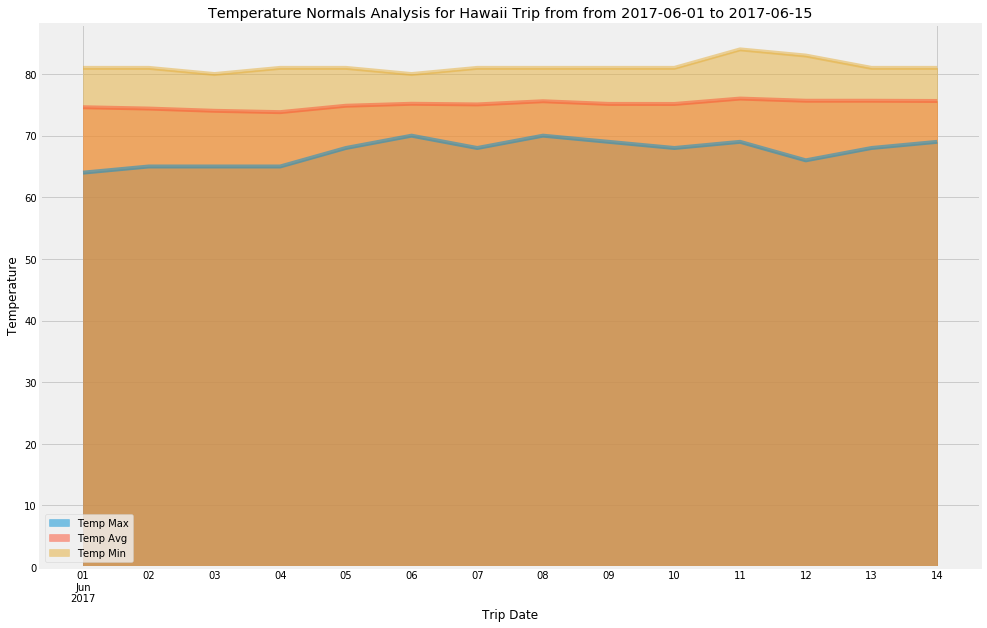

In [28]:
# Plot the daily normals as an area plot with `stacked=False`
trip_norm_df.plot(kind="area", stacked=False, figsize=(15,10), alpha=0.5)
plt.title(f"Temperature Normals Analysis for Hawaii Trip from from {trip_start} to {trip_end}")
plt.xlabel("Trip Date")
plt.ylabel("Temperature")
plt.xticks = (trip_norm_df.index)
plt.legend(loc="best")
plt.savefig("Images/trip_normals.png", bbox_inches = "tight")